# **Exploratory Data Analysis**

Import Packages

In [27]:
import pandas as pd
pd.set_option('display.width', 1000)

import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Visualization
import matplotlib.pyplot as plt

from torchinfo import summary

import xgboost as xgb
from xgboost import XGBRegressor

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#--- Starting Here ---#

In [3]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [6]:
NVDA = 'NVDA'
SEMICONDUCTORS = ["TSM", "AVGO", "AMD", "ASML", "MRVL", "ON", "NVDA"]
scaler = MinMaxScaler(feature_range=(0, 1)) # Scaling RSI values for more relatable trends

semiConductor_data = yf.download(NVDA, start='2010-01-01', end='2024-01-01')
semiConductor_data.columns = [col[0] for col in semiConductor_data.columns]
semiConductor_data['Ticker'] = NVDA
semiConductor_data['RSI'] = calculate_rsi(semiConductor_data['Close'], window=14)
semiConductor_data['RSI_Scaled'] = scaler.fit_transform(semiConductor_data['RSI'].values.reshape(-1, 1))
semiConductor_data.reset_index(inplace=True)
semiConductor_data = semiConductor_data[['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI', 'RSI_Scaled']]
                                                            
#print(f"Total Data Length: {len(semiConductor_data)}")

for stock in SEMICONDUCTORS:
    stock_data = yf.download(stock, start="2010-01-01", end="2024-01-01")
                                                                                                            
    stock_data['Ticker'] = stock
    stock_data['RSI'] = calculate_rsi(stock_data['Close'], window=14)

    stock_data['RSI_Scaled'] = scaler.fit_transform(stock_data['RSI'].values.reshape(-1, 1))
    stock_data['Close_Scaled'] = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))
    stock_data['High_Scaled'] = scaler.fit_transform(stock_data['High'].values.reshape(-1, 1))
    stock_data['Low_Scaled'] = scaler.fit_transform(stock_data['Low'].values.reshape(-1, 1))
    stock_data['Open_Scaled'] = scaler.fit_transform(stock_data['Open'].values.reshape(-1, 1))
    stock_data['Volume_Scaled'] = scaler.fit_transform(stock_data['Volume'].values.reshape(-1, 1))
    
    stock_data.reset_index(inplace=True)
    stock_data = stock_data[['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI', 'RSI_Scaled']]
    stock_data.columns = [col[0] for col in stock_data.columns]

    semiConductor_data = pd.concat([semiConductor_data, stock_data], ignore_index=True)

    #print([val[0] for val in semiConductor_data.columns.tolist()])
    #print(f"Total Data Length: {len(semiConductor_data)}")

semiConductor_data = semiConductor_data.dropna()
semiConductor_data.to_csv("semiconductorData.csv", index=False)
print([ i for i in semiConductor_data['Ticker'].unique()])
for stock in SEMICONDUCTORS:
    print(f"{stock} rows: {len(semiConductor_data.loc[semiConductor_data['Ticker'] == stock])}")
#'RSI', 'Close', 'High', 'Low', 'Open', 'Volume'
print(semiConductor_data.columns)
semiConductor_data.drop(columns=['Date'], inplace=True)
print(semiConductor_data.dtypes)
semiConductor_data['Ticker'], conversion = pd.factorize(semiConductor_data['Ticker'])
print(f"Conversion: {conversion}")
semiConductor_data.head(5)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['NVDA', 'TSM', 'AVGO', 'AMD', 'ASML', 'MRVL', 'ON']
TSM rows: 3509
AVGO rows: 3509
AMD rows: 3509
ASML rows: 3509
MRVL rows: 3509
ON rows: 3509
NVDA rows: 7018
Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI', 'RSI_Scaled'], dtype='object')
Close         float64
High          float64
Low           float64
Open          float64
Volume          int64
Ticker         object
RSI           float64
RSI_Scaled    float64
dtype: object
Conversion: Index(['NVDA', 'TSM', 'AVGO', 'AMD', 'ASML', 'MRVL', 'ON'], dtype='object')


,Close,High,Low,Open,Volume,Ticker,RSI,RSI_Scaled
13,0.377381,0.393430,0.375088,0.386322,1067916000,0,24.688364,0.225086
14,0.383800,0.391137,0.380820,0.383571,643676000,0,29.603715,0.276049
15,0.371649,0.384488,0.371420,0.381966,714636000,0,21.978056,0.196986
16,0.381737,0.383112,0.367293,0.371419,812504000,0,27.104712,0.250139
17,0.368897,0.386093,0.363624,0.384717,687764000,0,26.086941,0.239587


In [8]:
class lstmDataset(Dataset):
    def __init__(self, data, features, targets, input_window=30, output_window=5):
        self.data = torch.FloatTensor(data.values)
        self.input_window = input_window
        self.output_window = output_window
    def __len__(self):
        return len(self.data) - self.input_window - self.output_window + 1

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.input_window]
        y = self.data[idx + self.input_window : idx + self.input_window + self.output_window, 7]  # Assuming column 6 is the target
        return x, y

In [ ]:
features = ["Close", "High", "Low", "Open", "Volume"]
targets = ["RSI_Scaled"]

company_datasets = {}
tickers = semiConductor_data['Ticker'].unique()

# Create an lstmDataset for each company and store it in company_datasets
for ticker in tickers:
    data = semiConductor_data[semiConductor_data['Ticker'] == ticker]
    company_datasets[ticker] = lstmDataset(data, input_window=30, output_window=5, features=features, targets=targets)
#print(company_datasets)

batch_size = 32 

train_split = 0.8
val_split = 0.1
test_split = 0.1

# Create DataLoaders for training, validation, and testing
train_loaders = {}
val_loaders = {}
test_loaders = {}

for ticker, dataset in company_datasets.items():
    dataset_size = len(dataset)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = dataset_size - train_size - val_size  # Remaining samples for testing

    # Perform the split
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loaders[ticker] = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loaders[ticker] = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loaders[ticker] = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for i in range(len(tickers)):
    example_ticker = tickers[i]
    print(f"Ticker: {example_ticker}")
    print(f"Train Loader Size: {len(train_loaders[example_ticker])}")
    print(f"Validation Loader Size: {len(val_loaders[example_ticker])}")
    print(f"Test Loader Size: {len(test_loaders[example_ticker])}")


Ticker: 0
Train Loader Size: 175
Validation Loader Size: 22
Test Loader Size: 22
Ticker: 1
Train Loader Size: 87
Validation Loader Size: 11
Test Loader Size: 11
Ticker: 2
Train Loader Size: 87
Validation Loader Size: 11
Test Loader Size: 11
Ticker: 3
Train Loader Size: 87
Validation Loader Size: 11
Test Loader Size: 11
Ticker: 4
Train Loader Size: 87
Validation Loader Size: 11
Test Loader Size: 11
Ticker: 5
Train Loader Size: 87
Validation Loader Size: 11
Test Loader Size: 11
Ticker: 6
Train Loader Size: 87
Validation Loader Size: 11
Test Loader Size: 11


Define LSTM Model

In [25]:
class LSTMRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LSTMRegressionModel, self).__init__()
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=input_size, 
                             hidden_size=256, 
                             batch_first=True, 
                             dropout=0)
        
        self.lstm2 = nn.LSTM(input_size=256, 
                             hidden_size=128, 
                             batch_first=True, 
                             dropout=0.2)

        self.lstm3 = nn.LSTM(input_size=128,
                             hidden_size=128,
                             batch_first=True,
                             dropout=0.2)
        
        self.lstm4 = nn.LSTM(input_size=128, 
                             hidden_size=64, 
                             batch_first=True, 
                             dropout=0.1)
        
        # Fully connected layers
        self.dense1 = nn.Linear(64, 128)
        self.dense2 = nn.Linear(128, 64)
        self.dense3 = nn.Linear(64, output_size)
        
        # Activation functions and dropout
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.15)

        # Batch Normalization
        self.bn = nn.BatchNorm1d(num_features=64)
        
    def forward(self, x):

        out, _ = self.lstm1(x)
        #out = self.bn(30)
        out, _ = self.lstm2(out)
        out , _ = self.lstm3(out)
        out, (hn, _) = self.lstm4(out)  # Use the hidden state from the last LSTM
        
        out = self.dense1(out)
        out = self.relu(out)

        out = self.dense2(out)
        out = self.relu(out)

        out = self.dense3(out) 
        out = self.relu(out)
        return out

In [33]:
epochs = 20
model = LSTMRegressionModel(input_size=8, output_size=5).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = torch.nn.MSELoss()

summary(model, input_size=(32, 30, 8))

TypeError: 'ModelStatistics' object is not callable

In [26]:
losses = []  
i = 0

for ticker, loader in train_loaders.items(): 
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=25, verbose=True)
    for epoch in range(epochs):
        model.train()
        for batch_idx, (x_batch, y_batch) in enumerate(loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
                
            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f"Company: {ticker}, Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in val_loaders[ticker]:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_targets).item()
        val_loss /= len(val_loaders[ticker]) 
        
        scheduler.step(val_loss)

plt.plot(losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


c:\Users\lordw\Documents\ML Projects\forecastRSI\venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 5])) that is different to the input size (torch.Size([32, 30, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (30) must match the size of tensor b (32) at non-singleton dimension 1

Average Test Loss: 0.030897607405980427
[0, 1, 2, 3, 4]
(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.08555782 0.12933478 0.14808989 0.18708275 0.36716112]


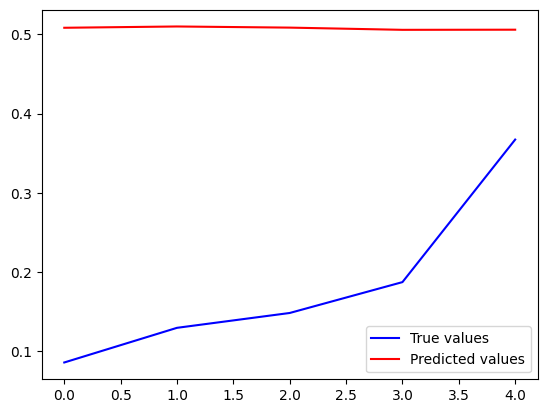

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.57446945 0.53429276 0.60863227 0.5495778  0.5050304 ]


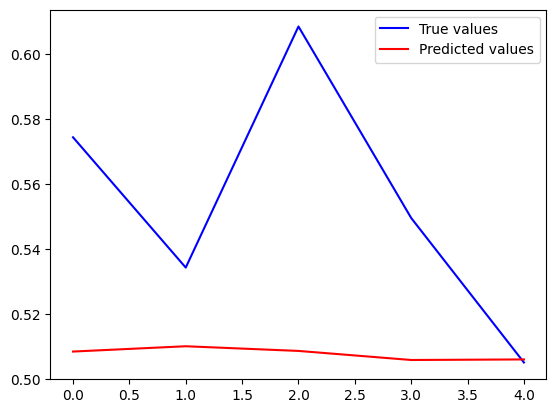

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.5367767  0.57516956 0.6232372  0.57152665 0.57994616]


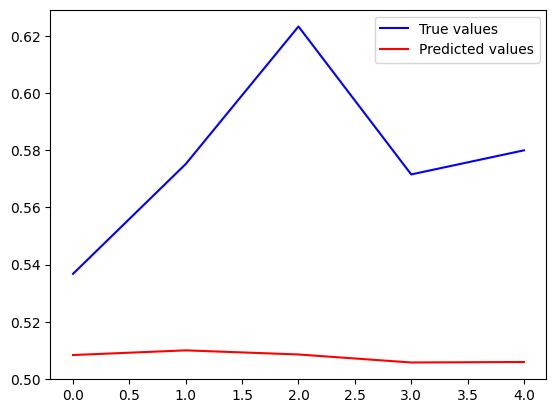

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.5793304  0.46247244 0.4243023  0.3969815  0.3747978 ]


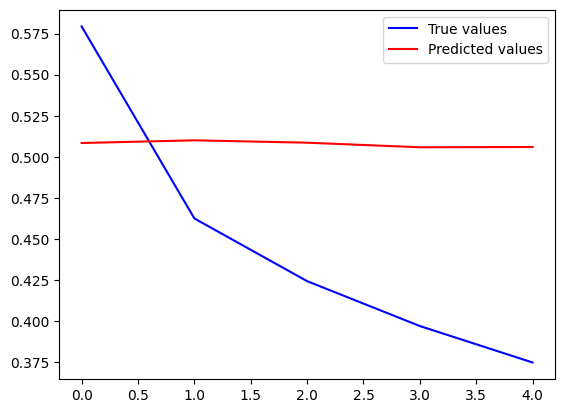

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.348104   0.4088965  0.5197493  0.50856924 0.50856924]


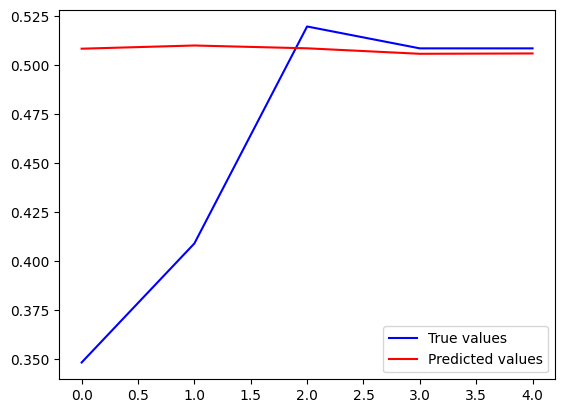

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.37156868 0.3629621  0.26031584 0.26849067 0.3073283 ]


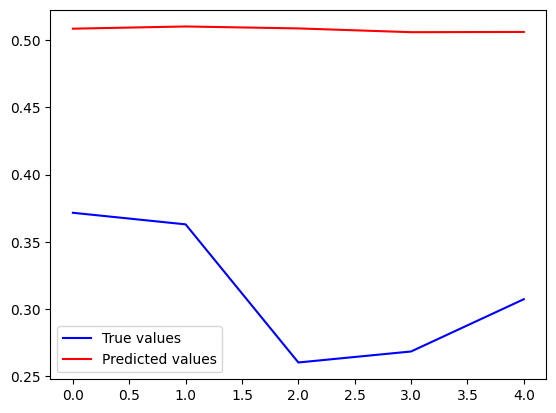

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.51906615 0.40455267 0.4140239  0.4483077  0.45304486]


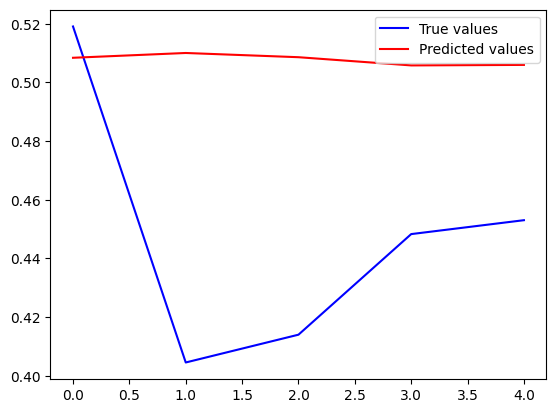

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.33851638 0.401869   0.44764093 0.52715963 0.5714492 ]


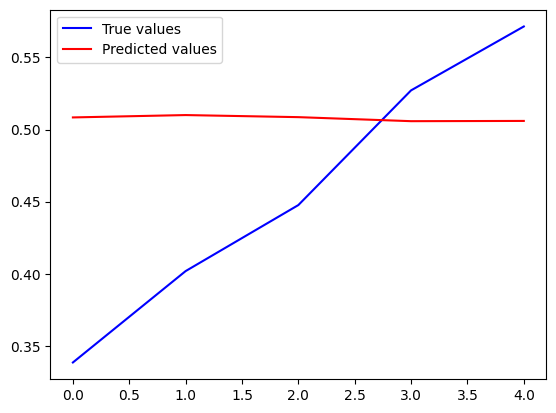

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.4943179 0.5043201 0.5026806 0.6250353 0.6224472]


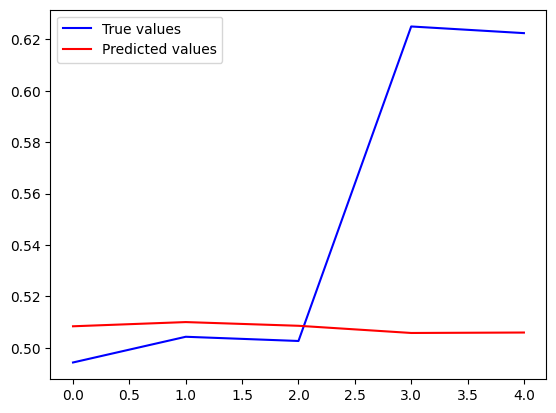

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.4364074  0.47704428 0.4357973  0.34476995 0.33007786]


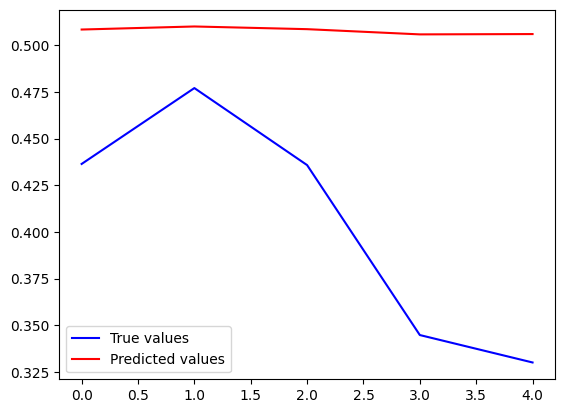

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.6115873  0.57931924 0.51820916 0.5538923  0.7316481 ]


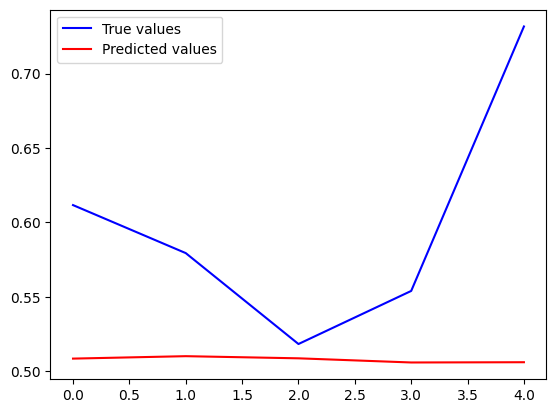

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.8227895  0.8013226  0.8166753  0.70905155 0.7098152 ]


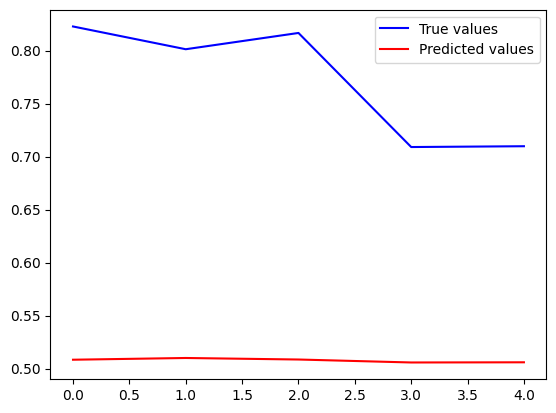

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.5626616  0.52346486 0.54555506 0.5499634  0.5822159 ]


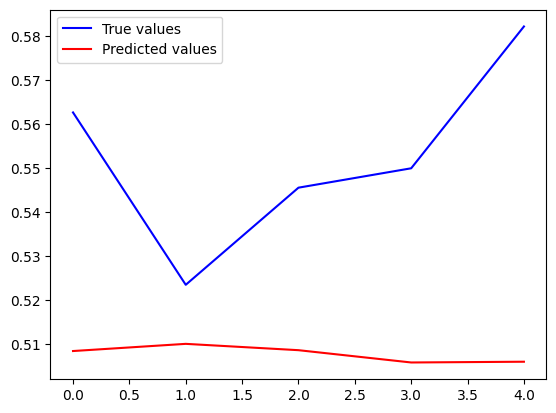

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.17020236 0.10060615 0.08174586 0.08555782 0.12933478]


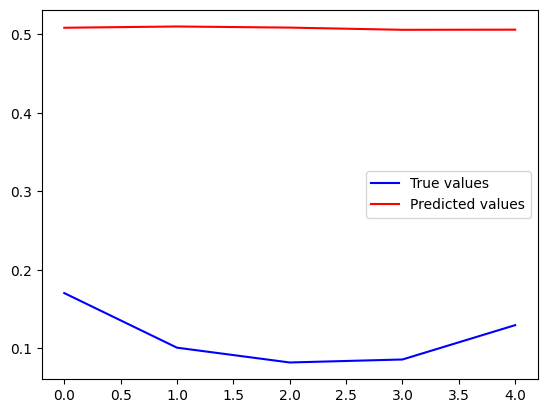

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.5473318  0.53287834 0.4493992  0.5112349  0.56472546]


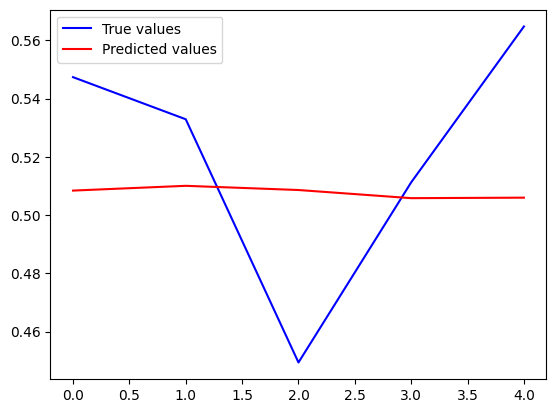

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.5999889  0.48106763 0.40432766 0.52218544 0.59301865]


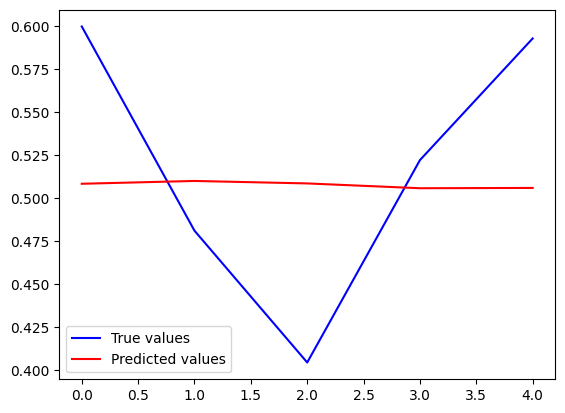

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.34671783 0.49432012 0.45013225 0.4943985  0.52808774]


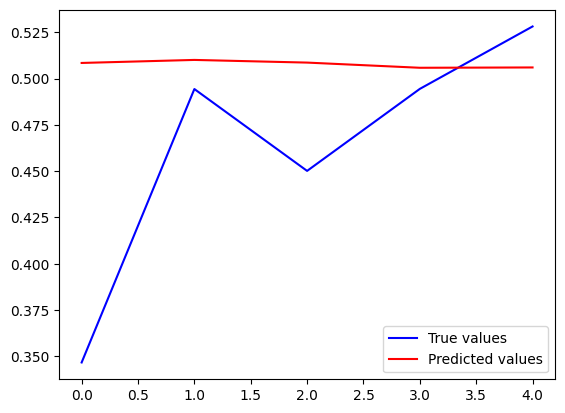

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.34340316 0.3343188  0.3177116  0.29128328 0.40734774]


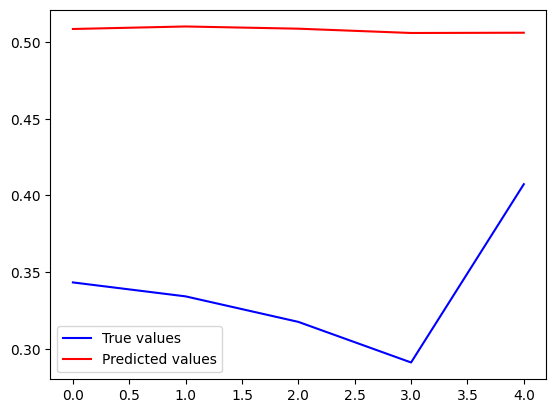

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.48822927 0.55216837 0.5107914  0.3743483  0.41384554]


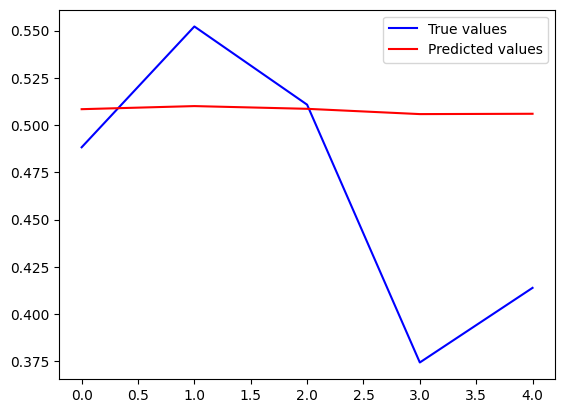

(32, 5)
(32, 5)
Predictions for 0: [0.5083999 0.5100331 0.5085934 0.5057976 0.5059696]
True values for 0: [0.8978382  0.91612434 0.9133562  0.89112747 0.8764505 ]


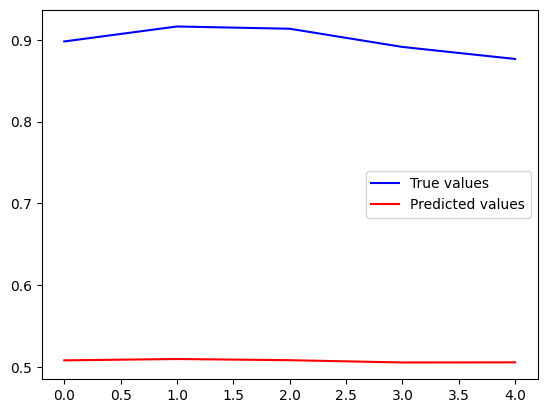

In [24]:
model.eval()

test_loss = 0
num_batches = 0

with torch.no_grad():
    i = 0
    for ticker, loader in test_loaders.items():
        i += 1
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            y_pred = model(x_batch)
            
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
            num_batches += 1
            
            if num_batches % 100 == 0:
                print(f"Test Loss after {num_batches} batches: {test_loss / num_batches}")
        
        if i == 2:
            break

avg_test_loss = test_loss / num_batches
print(f"Average Test Loss: {avg_test_loss}")

coordinates = np.linspace(start=0, stop=4, num=5, dtype=int).tolist()
print(coordinates)

ticker = 0
j = 0
for x_batch, y_batch in test_loaders[ticker]:
    j += 1
    
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
    y_pred = model(x_batch)
    
    # Detach from the computation graph and move to CPU for plotting
    y_pred = y_pred.detach().cpu().numpy()
    y_batch = y_batch.cpu().numpy()

    print(y_batch.shape)
    print(y_pred.shape)
    print(f"Predictions for {ticker}: {y_pred[0]}")
    print(f"True values for {ticker}: {y_batch[0]}")
    
    plt.plot(coordinates, y_batch[0], color="blue", label="True values")
    plt.plot(coordinates, y_pred[0], color="red", label="Predicted values")
    plt.legend()
    plt.show()

    if j == 20:
        break